In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import pandas as pd

from sklearn.model_selection import train_test_split

data= pd.read_csv("data12.csv", dtype=float)
#data= data.dropna(axis=0,how='any')

data_phr={}
dataset={}
train_set={}
test_set={}
train_x={}
train_y={}
test_x={}
test_y={}
data_x={}
data_y={}

predict_arr={}
final_predict_arr={}

In [2]:
data_phr= pd.read_csv("phr.csv",usecols=[2])
data_phr= data_phr.dropna(axis=0,how='any')
data_phr[data_phr<0.01] = 0
data_phr[data_phr>=0.01] = 1

data_join= data.join(data_phr)
data_join= data_join.dropna(axis=0,how='any')

dataset= data_join.drop(['x','y','d1ndwi','d2ndwi','d1evi','phreat','d2evi','d1prec','d2prec','d1ndvi','d2ndvi','d1temp','d2temp','evapot','elevation','gwlvl','t1','t2','d1sat0','d2sat0','d1sat1','d2sat1','d1sat2','d2sat2','d1sat3','d2sat3','d1sat4','d2sat4'], axis=1)
#dataset[i]= data.drop(['x','y','phreat'],axis=1)


train_set, test_set = train_test_split(dataset, test_size=0.2)
print(len(train_set), "train"  ,"+" , len(test_set), "test")

train_x, train_y = train_set, train_set.pop('ph'+str(1))
test_x, test_y = test_set, test_set.pop('ph'+str(1))

#print(str(dataset[0].shape[0])+'+'+str(data_phr[0].shape[0]))

32178 train + 8045 test


In [3]:
import tensorflow as tf
feature_columns = []

for key in train_x.keys():
    feature_columns.append(tf.feature_column.numeric_column(key=key))

classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                        hidden_units=[50,100,50],
                                        n_classes=2,
                                        optimizer=tf.train.AdamOptimizer(
                                        learning_rate=0.05)
                                       )
def train_func(train_x,train_y):
    dataset=tf.data.Dataset.from_tensor_slices((dict(train_x), train_y))
    dataset = dataset.shuffle(1000).repeat().batch(100)
    return dataset

def eval_input_fn(features, labels, batch_size):
    features=dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)
    return dataset

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Zikei\\AppData\\Local\\Temp\\tmphiywbi7b', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001A664DABC88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [4]:
classifier.train(input_fn=lambda:train_func(train_x,train_y),steps=2000)

Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Zikei\AppData\Local\Temp\tmphiywbi7b\model.ckpt.
INFO:tensorflow:loss = 9831.592, step = 1
INFO:tensorflow:global_step/sec: 104.228
INFO:tensorflow:loss = 67.401024, step = 101 (0.961 sec)
INFO:tensorflow:global_step/sec: 160.943
INFO:tensorflow:loss = 64.001724, step = 201 (0.650 sec)
INFO:tensorflow:global_step/sec: 148.324
INFO:tensorflow:loss = 67.302376, step = 301 (0.645 sec)
INFO:tensorflow:global_step/sec: 184.315
INFO:tensorflow:loss = 69.05399, step = 401 (0.542 sec)
INFO:tensorflow:global_step/sec: 161.722
INFO:tensorflow:loss = 68.831764, step = 501 (0.619 sec)
INFO:ten

In [5]:
predict_arr = []
predictions = classifier.predict(input_fn=lambda:eval_input_fn(test_x,labels=test_y,batch_size=100))

for predict in predictions:
    predict_arr.append(predict['probabilities'].argmax())

result = predict_arr == test_y
result1 = [w for w in result if w == True]
print("Accuracy"+str(1)+" is %s"%str((len(result1)/len(result))))

data_x, data_y = data_join, data_join.pop('ph'+str(1))

final_predict_arr = []
predictions = classifier.predict(input_fn=lambda:eval_input_fn(data_x,labels=data_y,batch_size=100))

for predict in predictions:
    final_predict_arr.append(predict['probabilities'].argmax())

result = final_predict_arr == data_y
result1 = [w for w in result if w == True]
print("Accuracy"+str(1)+" is %s"%str((len(result1)/len(result))))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Users\Zikei\AppData\Local\Temp\tmphiywbi7b\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy1 is 0.6038533250466128
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Zikei\AppData\Local\Temp\tmphiywbi7b\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy1 is 0.5947094945677845


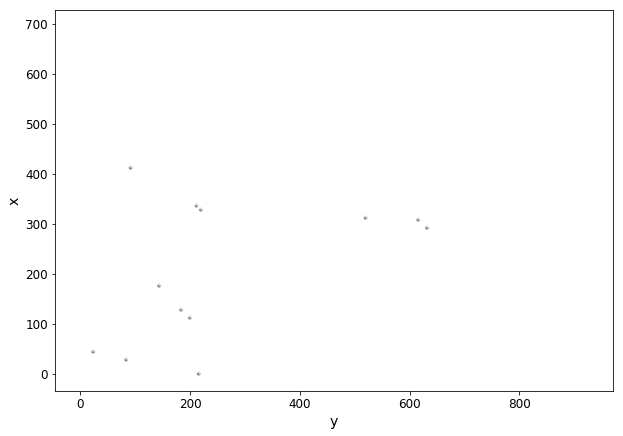

In [6]:
data_join.plot(kind="scatter",x="y",y="x",alpha=0.4,s=10,figsize=(10,7),c=final_predict_arr)

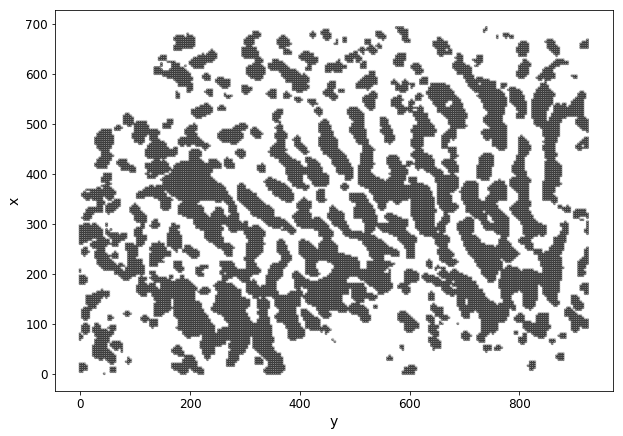

In [7]:
data_join.plot(kind="scatter",x="y",y="x",alpha=0.4,s=5,figsize=(10,7),c=data_y)

In [8]:
max(final_predict_arr)

1